In [749]:
import os
import math
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [738]:
students_mat = pd.read_csv(os.path.join('data', 'student-mat.csv'))
students_por = pd.read_csv(os.path.join('data', 'student-por.csv'))

In [739]:
students = pd.concat([students_mat, students_por], axis=0)

In [740]:
students['grade'] = (students['G1'] + students['G1'] + students['G3']) / 3
students['alc'] = students['Walc'] + students['Dalc']
students = students.drop(columns=['Walc', 'Dalc', 'G1', 'G2', 'G3', 'school'])

In [741]:
students.head(3)

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,higher,internet,romantic,famrel,freetime,goout,health,absences,grade,alc
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,yes,no,no,4,3,4,3,6,5.333333,2
1,F,17,U,GT3,T,1,1,at_home,other,course,...,yes,yes,no,5,3,3,3,4,5.333333,2
2,F,15,U,LE3,T,1,1,at_home,other,other,...,yes,yes,no,4,3,2,3,10,8.000000,5


In [742]:
numeric_cols = ['age',
                'traveltime',
                'studytime',
                'failures',
                'famrel',
                'freetime',
                'goout',
                'health',
                'absences',
                'grade',
                'alc']
is_categorical = []
for col in students.columns:
    if col in numeric_cols:
        is_categorical.append(0)
    else:
        is_categorical.append(1)

In [743]:
categorical_dict = {}
for col in students.columns:
    if students[col].dtype == 'object':
        le = LabelEncoder() 
        students[col] = le.fit_transform(students[col])
        categorical_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [744]:
students.head(3)

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,higher,internet,romantic,famrel,freetime,goout,health,absences,grade,alc
0,0,18,1,0,0,4,4,0,4,0,...,1,0,0,4,3,4,3,6,5.333333,2
1,0,17,1,0,1,1,1,0,2,0,...,1,1,0,5,3,3,3,4,5.333333,2
2,0,15,1,1,1,1,1,0,2,2,...,1,1,0,4,3,2,3,10,8.000000,5


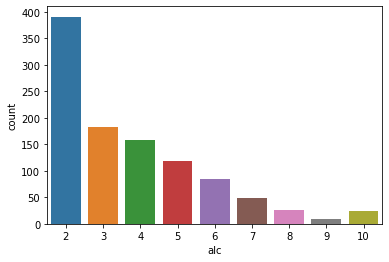

In [712]:
sns.countplot(students['alc'])

In [713]:
students.loc[students['alc'] <= 3, 'alc'] = 0
students.loc[(students['alc'] > 3) & (students['alc'] <= 5), 'alc'] = 1
students.loc[students['alc'] > 5, 'alc'] = 2

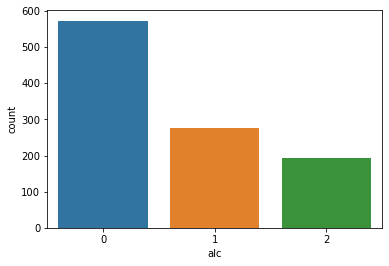

In [714]:
sns.countplot(students['alc'])

In [651]:
categorical_dict['alc'] = {'low' : 1, 'medium': 2, 'high': 3}

In [652]:
pprint(categorical_dict)

{'Fjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Pstatus': {'A': 0, 'T': 1},
 'activities': {'no': 0, 'yes': 1},
 'address': {'R': 0, 'U': 1},
 'alc': {'high': 3, 'low': 1, 'medium': 2},
 'famsize': {'GT3': 0, 'LE3': 1},
 'famsup': {'no': 0, 'yes': 1},
 'guardian': {'father': 0, 'mother': 1, 'other': 2},
 'higher': {'no': 0, 'yes': 1},
 'internet': {'no': 0, 'yes': 1},
 'nursery': {'no': 0, 'yes': 1},
 'paid': {'no': 0, 'yes': 1},
 'reason': {'course': 0, 'home': 1, 'other': 2, 'reputation': 3},
 'romantic': {'no': 0, 'yes': 1},
 'schoolsup': {'no': 0, 'yes': 1},
 'sex': {'F': 0, 'M': 1}}


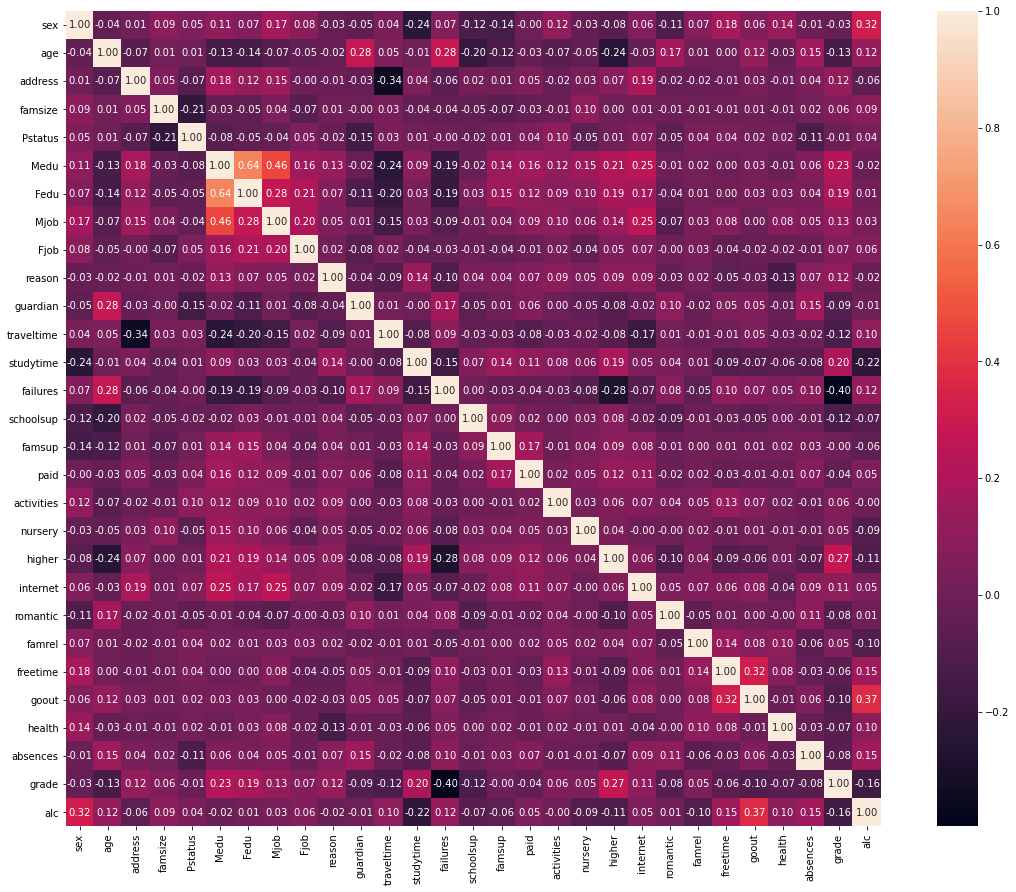

In [754]:
plt.figure(figsize=(20, 15))
sns.heatmap(students.corr(), annot=True, square=True, fmt='0.2f')

In [653]:
X = torch.from_numpy(students.iloc[:, :-1].values)
y = torch.from_numpy(students.iloc[:, -1].values)

In [654]:
class NaiveBayesClassifier(BaseEstimator):
    def __init__(self, offset=1):
        self.offset = offset
        pass
    
    def fit(self, X, y, **kwargs):
        if 'is_categorical' not in kwargs:
            raise ValueError('must pass \'is_categorical\' to fit through **kwargs')
        self.is_categorical = kwargs['is_categorical']
        size = X.shape[0]
        
        self.nb_features = X.shape[1]
        y_uvals = y.unique()
        self.nb_class = len(y_uvals)
        self.class_probs = y.bincount().float() / size
        
        features_maxvals = torch.zeros((self.nb_features,), dtype=torch.int32)
        for j in range(self.nb_features):
            features_maxvals[j] = X[:, j].max()
        
        cond_probs = [] 
        for i in range(self.nb_class):
            cond_probs.append([])
            idx = torch.where(y == y_uvals[i])[0]
            elts = X[idx]
            
            size_class = elts.shape[0]
            for j in range(self.nb_features):
                cond_probs[i].append([])
                for k in range(features_maxvals[j] + 1):
                    p_x_k = (torch.where(elts[:, j] == k)[0].shape[0] + self.offset) / size_class
                    cond_probs[i][j].append(p_x_k)
        self.cond_probs = cond_probs
        return 0
    
    def gaussian_likelihood(X, mean, std):
        return -(1 / (2 * math.pi * std.pow(2))) * torch.exp(-0.5 * ((X - mean) / std).pow(2))
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.unsqueeze(0)
        
        nb_samples = X.shape[0]
        pred_probs = torch.zeros((nb_samples, self.nb_class), dtype=torch.float32)
        for k in range(nb_samples):
            elt = X[k]
            for i in range(self.nb_class):
                pred_probs[k][i] = self.class_probs[i]
                prob_feature_per_class = self.cond_probs[i]
                for j in range(self.nb_features):
                    pred_probs[k][i] *= prob_feature_per_class[j][elt[j]]
        return pred_probs.argmax(dim=1)

In [678]:
nbc = NaiveBayesClassifier()

cross_val_score(nbc, X, y, cv=5, scoring='accuracy').mean()

0.5450680898049319

In [679]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

cross_val_score(mnb, X, y, cv=5, scoring='accuracy').mean()

0.5517252484357748